# (PART) EDA {-}

# How do you read the dataset from the `data/` folder before deployment?

## Explanation

Before deploying any machine learning model, it's essential to understand the data it was trained on. This step helps ensure consistent preprocessing, reproducibility, and seamless integration across tools.

In the CDI deployment pipeline, we assume that cleaned and prepared data (like Titanic or Iris datasets) is stored in a `data/` folder at the project root. This structure allows for organized workflows and compatibility with scripts and APIs.

We'll demonstrate how to read a typical dataset using both **Python** and **R**, preparing it for evaluation or serving.

## Python Code



In [ ]:
import pandas as pd

# Load the Titanic dataset
df = pd.read_csv("data/titanic.csv")

# Preview the first few rows
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## R Code

```{r}
library(readr)

# Load the Titanic dataset
df <- read_csv("data/titanic.csv")

# Preview the first few rows
head(df)
```

> ✅ Takeaway: Store your datasets in a consistent data/ directory and load them early to ensure your models, APIs, and frontends share the same input structure.

# How do you train and save multiple models for deployment?

## Explanation

Once your dataset is loaded and preprocessed, the next step in the deployment pipeline is to train machine learning models and save them for reuse. Saving models allows you to:

- Avoid retraining every time the API is restarted
- Load models instantly in production
- Maintain version control and reproducibility

In this example, we’ll use the Titanic dataset and train multiple classification models. We'll then save each model as a `.joblib` file into a `models/` folder for future deployment.

## Python Code



In [ ]:
# scripts/train_n_save_models.py
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import joblib

# Load and preprocess dataset
df = pd.read_csv("data/titanic.csv")
df.dropna(subset=["Age", "Fare", "Embarked", "Sex", "Survived"], inplace=True)
df["Sex"] = df["Sex"].astype("category").cat.codes
df["Embarked"] = df["Embarked"].astype("category").cat.codes

X = df[["Pclass", "Sex", "Age", "Fare", "Embarked"]]
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to train
models = {
    "logistic_regression": LogisticRegression(max_iter=200),
    "random_forest": RandomForestClassifier(),
    "gradient_boosting": GradientBoostingClassifier(),
    "svc": SVC(probability=True),
    "decision_tree": DecisionTreeClassifier(),
    "knn": KNeighborsClassifier(),
    "naive_bayes": GaussianNB()
}

# Ensure models directory exists
os.makedirs("models", exist_ok=True)

# Train and save each model
for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, f"models/{name}.joblib")
    print(f"✅ Saved: models/{name}.joblib")


✅ Saved: models/logistic_regression.joblib
✅ Saved: models/random_forest.joblib
✅ Saved: models/gradient_boosting.joblib
✅ Saved: models/svc.joblib
✅ Saved: models/decision_tree.joblib
✅ Saved: models/knn.joblib
✅ Saved: models/naive_bayes.joblib


## R Code

```{r}
# R version not included in this example as the deployment focus uses joblib (.joblib) in Python.
# Alternative: Save R models using saveRDS() if needed for Shiny APIs.
```

> ✅ Takeaway: Save each trained model in a dedicated models/ folder using a consistent naming scheme. This enables fast, reliable deployment via your API.

# How do you evaluate models before deployment?

## Explanation

Before deploying machine learning models, it's important to evaluate their performance on **unseen test data**. This helps you:

- Compare models based on accuracy, precision, recall, and F1 score
- Select the best model(s) for deployment
- Detect overfitting or underfitting
- Create a summary table for documentation or reporting

In this Q&A, we load previously saved models from the `models/` folder, evaluate them on test data, and store the results in a single CSV file: `evaluation_summary.csv`.

## Python Code



In [17]:
# scripts/evaluate_models.py

import os
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Paths
MODEL_DIR = "models"
DATA_PATH = "data/titanic.csv"
OUTPUT_FILE = "data/evaluation_summary.csv"

# Load and preprocess Titanic data
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=["Age", "Fare", "Embarked", "Sex", "Survived"])
df["Sex"] = df["Sex"].astype("category").cat.codes
df["Embarked"] = df["Embarked"].astype("category").cat.codes
df["Survived"] = df["Survived"].astype(int)

features = ["Pclass", "Sex", "Age", "Fare", "Embarked"]
X = df[features]
y = df["Survived"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store results
results = []

# Evaluate all saved models
for filename in os.listdir(MODEL_DIR):
    if filename.endswith(".joblib"):
        model_path = os.path.join(MODEL_DIR, filename)
        model = joblib.load(model_path)
        model_name = filename.replace(".joblib", "")

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Use macro avg for simplicity
        precision = report["macro avg"]["precision"]
        recall = report["macro avg"]["recall"]
        f1 = report["macro avg"]["f1-score"]

        results.append({
            "Model": model_name,
            "Accuracy": round(acc, 4),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1 Score": round(f1, 4)
        })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_FILE, index=False)
print(f"\n✅ Evaluation summary saved to: {OUTPUT_FILE} see results below:\n")

print(results_df)



✅ Evaluation summary saved to: data/evaluation_summary.csv see results below:

                 Model  Accuracy  Precision  Recall  F1 Score
0                  knn    0.6853     0.6841  0.6867    0.6838
1                  svc    0.6364     0.6378  0.6109    0.6038
2  logistic_regression    0.7902     0.8057  0.7737    0.7784
3    gradient_boosting    0.7762     0.7858  0.7612    0.7652
4        random_forest    0.7692     0.7690  0.7600    0.7625
5          naive_bayes    0.7692     0.7734  0.7566    0.7600
6        decision_tree    0.6853     0.6816  0.6732    0.6746


## R Code

```{r}
# For a Python-based deployment workflow, use Python for evaluation.
# For R-based workflows, use caret::confusionMatrix() or metrics from modelr or yardstick.
```

> ✅ Takeaway: Always evaluate your models and store the results before deployment. This ensures you deploy with confidence and clarity.

# How do you serve saved models as prediction endpoints using FastAPI?

## Explanation

Once you've saved your trained models, the next step is to create an API that loads those models and makes them available for real-time prediction. FastAPI is a lightweight, high-performance framework that’s ideal for this.

In this Q&A, we define a FastAPI app that:

- Loads all `.joblib` models from the `models/` folder
- Defines a prediction route `/predict/{model_name}`
- Accepts JSON input using a `pydantic` schema
- Returns a prediction as a JSON response

## Python Code (Define FastAPI App)


```python
# scripts/model_api.py

import os
import joblib
import pandas as pd
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

# Load models dynamically
MODEL_DIR = "models"
models = {}

for fname in os.listdir(MODEL_DIR):
    if fname.endswith(".joblib"):
        model_name = fname.replace(".joblib", "")
        model_path = os.path.join(MODEL_DIR, fname)
        models[model_name] = joblib.load(model_path)

# Create FastAPI app
app = FastAPI()

# Define input schema
class InputData(BaseModel):
    Pclass: int
    Sex: int
    Age: float
    Fare: float
    Embarked: int

# Define output schema
class PredictionOutput(BaseModel):
    model: str
    prediction: int

# Route to list available models
@app.get("/models")
def list_models():
    return {"available_models": list(models.keys())}

# Route to predict using any loaded model
@app.post("/predict/{model_name}", response_model=PredictionOutput)
def predict(model_name: str, input_data: InputData):
    if model_name not in models:
        raise HTTPException(status_code=404, detail="Model not found.")

    input_df = pd.DataFrame([input_data.dict()])
    model = models[model_name]

    try:
        prediction = model.predict(input_df)[0]
        return PredictionOutput(model=model_name, prediction=int(prediction))
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))
```

## R Code

```{-}
# This deployment workflow is implemented in Python using FastAPI.
# For R, consider plumber for serving models as REST APIs.
```

> ✅ Takeaway: FastAPI allows you to create scalable prediction endpoints by loading saved models and exposing them through clean, documented routes.

# How do you run and test your FastAPI app using Uvicorn and Swagger UI?

## Explanation

After creating your FastAPI app, you need to **run it locally** to test prediction endpoints. The standard way to run FastAPI is through **Uvicorn**, an ASGI server that supports fast, async APIs.

When you run your app, FastAPI automatically provides an interactive, browser-based **Swagger UI** at `/docs`, where you can test endpoints and submit real input.

## Run Command (Terminal)
Assuming your FastAPI file is located at `scripts/model_api.py` and your app instance is named `app`, run:

```bash
uvicorn scripts.model_api:app --reload
```

- script.model_api is the Python path: folder + filename (without .py)
- :app refers to the FastAPI() instance inside the file
- --reload enables live reloading during development

> 

## Output (Sample)

INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process...

## Test in Your Browser
- Go: http://127.0.0.1:8000/docs
  
- You’ll see:
    - /models → GET endpoint to list all available models
    - /predict/{model_name} → POST endpoint with a form to test predictions

Click “**Try it out**” on any route, fill in the form, and hit **Execute** to see the response.



## Example JSON Input

{
  "Pclass": 1,
  "Sex": 1,
  "Age": 32.0,
  "Fare": 100.0,
  "Embarked": 2
}

## Troubleshooting

If you get Address already in use:

```bash
lsof -i :8000     # Find the PID
```

```bash
kill -9 <PID>     # Kill the process using the port
```

Or use an alternate port:\ like so:

```bash
uvicorn script.model_api:app --reload --port 8001
```

> ✅ Takeaway: FastAPI’s auto-generated Swagger UI lets you run and test prediction APIs right from your browser. Uvicorn runs the app, and /docs gives you an instant frontend for debugging.

# How do you visualize model evaluation results from CSV?

## Explanation

Once you've evaluated and stored model metrics (accuracy, precision, recall, F1) in a CSV file like `evaluation_summary.csv`, the next step is to visualize them for quick comparison.

Visualization helps:
- Identify the best-performing model
- Spot trade-offs (e.g., higher precision vs lower recall)
- Communicate results to others

We’ll use Python’s `pandas`, `matplotlib`, and `seaborn` to create performance bar plots.

## Python Code



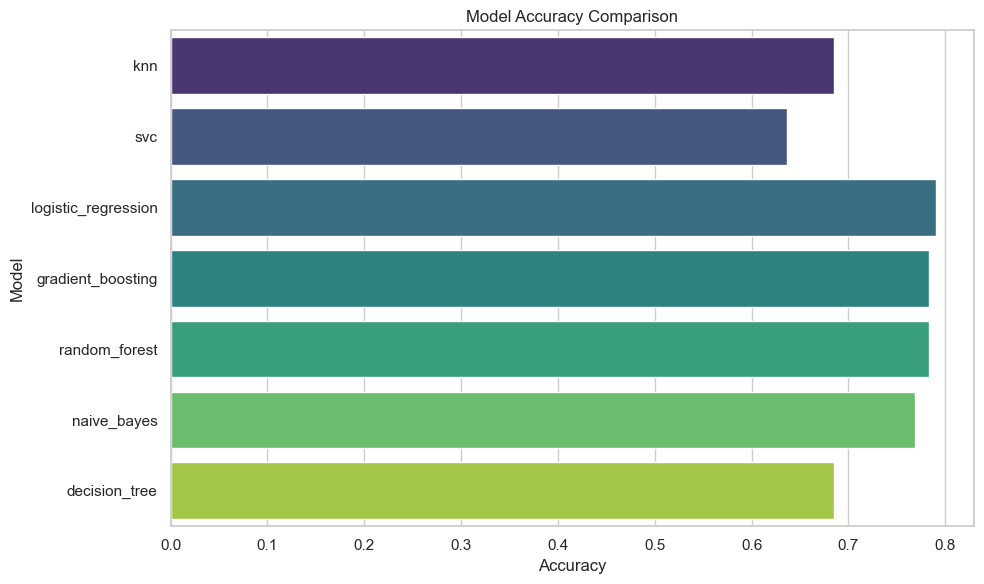

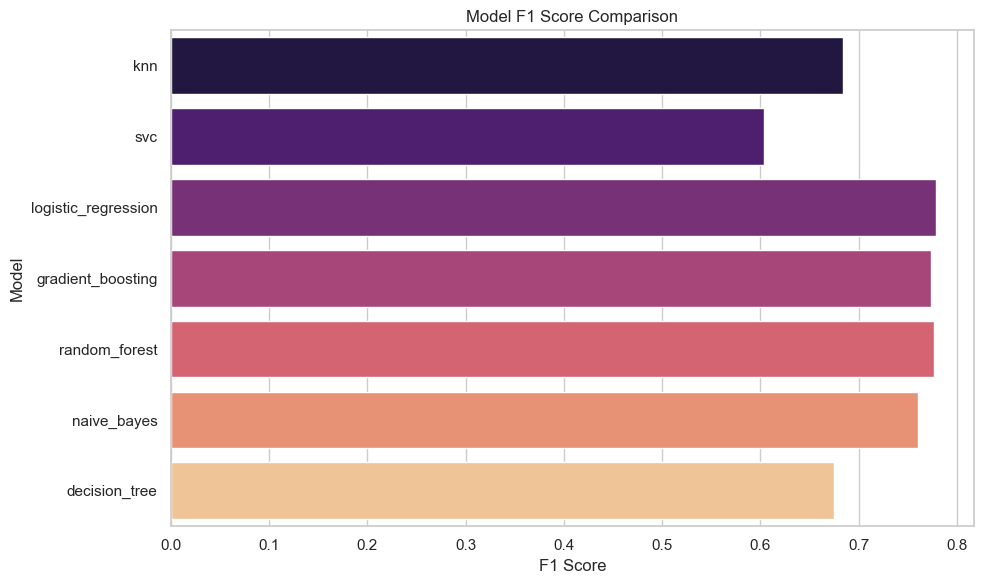

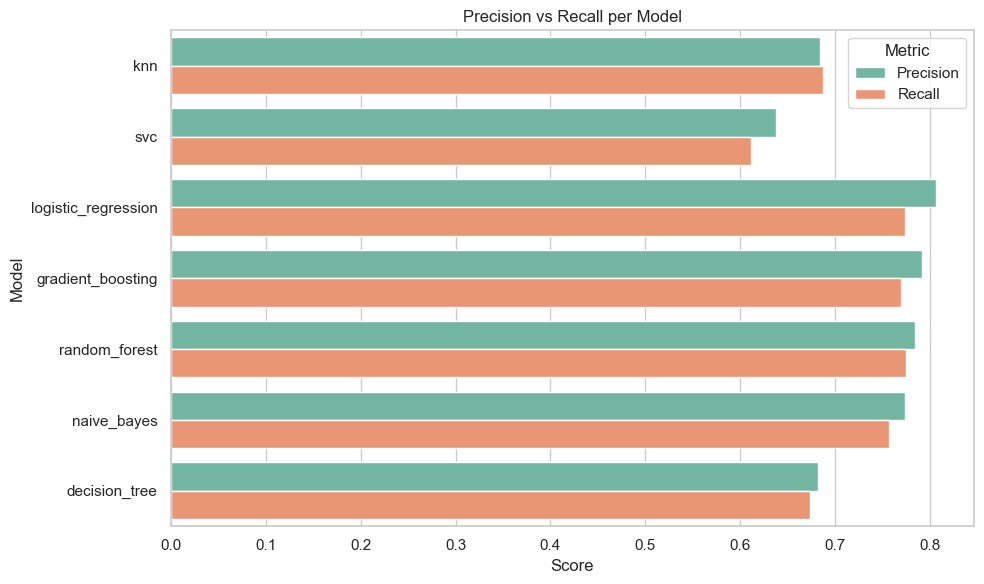

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Load evaluation summary
df = pd.read_csv("evaluation_summary.csv")

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot Accuracy
sns.barplot(x="Accuracy", y="Model", data=df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
# plt.savefig("accuracy_plot.png")
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
sns.barplot(x="F1 Score", y="Model", data=df, palette="magma")
plt.title("Model F1 Score Comparison")
plt.tight_layout()
# plt.savefig("f1_score_plot.png")
plt.show()

# Compare Precision vs Recall
df_melted = df.melt(id_vars="Model", value_vars=["Precision", "Recall"],
                    var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Model", hue="Metric", data=df_melted, palette="Set2")
plt.title("Precision vs Recall per Model")
plt.tight_layout()
# plt.savefig("precision_recall_plot.png")
plt.show()

## R Code

```{r}
# For R visualization, use ggplot2:
df <- read.csv("evaluation_summary.csv")
library(ggplot2)
ggplot(df, aes(x = Accuracy, y = reorder(Model, Accuracy))) +
  geom_col(fill = "steelblue") +
  theme_minimal() +
  labs(title = "Model Accuracy Comparison")
```

> ✅ Takeaway: Visualizing model metrics makes it easier to select, explain, and justify your deployment choice. Graphs tell the story your numbers started.

# How do you get started with Docker before containerizing your model? {#docker-image-template}

## Explanation

Docker is a tool that lets you package your application — including code, dependencies, and environment — into a portable container. Containers run the same way across laptops, servers, and the cloud, making them perfect for deploying machine learning APIs.

Before containerizing your FastAPI model, you should first:

- Understand what Docker is
- Install and start Docker Desktop
- Build and run a basic Docker image

---

## Step 1: Install Docker Desktop

👉 [Download Docker for Mac](https://www.docker.com/products/docker-desktop/)  
👉 [Download Docker for Windows](https://www.docker.com/products/docker-desktop/)

Install it like any other application.

---

## Step 2: Start Docker Desktop

After installation:

- **Mac**: Open **Docker** from Launchpad or the Applications folder  
- **Windows**: Open **Docker Desktop** from the Start menu

You should see the 🐳 Docker whale icon appear in your menu bar or system tray.

✅ Wait for the message ➡️ `Docker is running`

---

## Step 3: Confirm Docker is Active

In your terminal, run:

```bash
docker info
```

You should see details like Docker version, containers, and storage. If you see an error like:

*Cannot connect to the Docker daemon...*

That means Docker is not running — go back and start Docker Desktop.

## Step 4: Write Your First Dockerfile

Create a folder named hello-docker, and inside it create a Dockerfile:

```dockerfile
FROM python:3.12-slim

WORKDIR /app

COPY . .

CMD ["python3", "-c", "print('🎉 Hello from Docker!')"]
```

## Step 5: Build and Run Your First Container

```bash
docker build -t hello-docker .
docker run hello-docker
```

You should see:

*🎉 Hello from Docker!*



## Step 6: Log in to Docker Hub

Before pushing images or scanning them, log in:

```bash
docker login
```

You can use:

- Your Docker ID or email
- Your password (not recommended)
- Or a Personal Access Token (PAT) (recommended)

🔐 Create a PAT here

Using a PAT is required if:

- You have 2FA enabled
- You’re part of an organization using SSO
- You want better security


## Step 7: Tag and Push Your Image

After login:

```bash
docker tag hello-docker yourusername/hello-docker
docker push yourusername/hello-docker
```

This makes your image accessible from the cloud or collaborators.

## Step 8: Scan Your Image with Docker Scout (Optional)

After building an image, Docker may suggest:

*View a summary of image vulnerabilities and recommendations → docker scout quickview*

```bash
docker scout quickview
```

Docker Scout checks for:

- Vulnerabilities in your base image
- Outdated dependencies
- Upgrade suggestions

> Make sure you’re logged in before using Scout

## Example Log Insights

- Cannot connect to the Docker daemon...
  - → Start Docker Desktop first and retry.
- Using a limited-scope PAT grants better security..
  - → Prefer PATs for login over full passwords.

> ✅ Takeaway: Understanding Docker basics — installation, login, and image scanning — prepares you for robust, secure ML model deployment and reproducibility..

# How do you containerize your model API using Docker for reproducible deployment?

## Explanation

Docker allows you to **package your model API and dependencies into a container** that runs the same way on any machine. This makes your deployment:

- Portable across teams and clouds
- Reproducible and isolated from system conflicts
- Easy to scale or integrate with CI/CD pipelines

We'll build a Docker container for your FastAPI model API that loads saved `.joblib` models and runs with Uvicorn.

## Project Structure

```plaintext
cdi-model-deployment/
├── script/
│   └── model_api.py
├── models/
│   └── [saved models here]
├── requirements.txt
└── Dockerfile
```

## Dockerfile

```dockerfile
# Base image
FROM python:3.12-slim

# Set working directory
WORKDIR /app

# Copy code and model directory
COPY script/model_api.py ./script/model_api.py
COPY models/ ./models/
COPY requirements.txt .

# Install dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Expose port for Uvicorn
EXPOSE 8000

# Run the API with Uvicorn
CMD ["uvicorn", "script.model_api:app", "--host", "0.0.0.0", "--port", "8000"]
```


## Libraries in requirements.txt (Minimum Needed)

```plaintext
fastapi==0.115.4
uvicorn==0.35.0
joblib==1.4.2
scikit-learn==1.6.0
pandas==2.2.3
gradio==5.9.1
streamlit==1.39.0
```

## Build the Docker Image

```bash
docker build -t model-api .
```

## Run the Docker Container

```bash
docker run -p 8000:8000 model-api
```

**Then test it at:**

http://127.0.0.1:8000/docs

## Optional: .dockerignore

To avoid copying your local venv or large files:

```plaintext
__pycache__/
venv/
*.csv
*.ipynb
```



>✅ Takeaway: Docker lets you containerize your model API so it runs identically on any machine — a must-have for production deployment.

# How do you tag and push your model image to Docker Hub?

## 📘 Explanation

Once you’ve built your Docker image locally (e.g., `model-api:latest`), you can share it with others or deploy it remotely by **tagging** it with your Docker Hub name and **pushing** it to your Docker Hub repository.

This makes your image accessible from anywhere using `docker pull`.

---

## Log into Docker Hub

```bash
docker login
```

You’ll be prompted to enter your Docker Hub username and password or Personal Access Token (PAT).

## Tag the image using your Docker Hub username

```bash
docker tag model-api your_dockerhub_username/model-api
```
> 🔁 Replace your_dockerhub_username with your Docker Hub username.

Example:

```bash
docker tag model-api tmbuza/model-api
```

## Push the image to Docker Hub

```bash
docker push your_dockerhub_username/model-api
```

Example:

```bash
docker push tmbuza/model-api
```

> Docker will upload the image layers and confirm when complete.
>
## Confirm image available publicly or privately

Visit your Docker Hub account and check under Repositories.

✅ You (or others) can now pull the image with:

```bash
docker pull your_dockerhub_username/model-api
```


Example:

```bash
docker pull tmbuza/model-api
```

> ✅ Takeaway: Tagging and pushing your image makes it accessible for deployment, collaboration, or reuse—especially valuable in reproducible ML workflows.

# How do you pull and run your model API image from Docker Hub?

## Explanation

After pushing your trained model image to Docker Hub, you can reuse it on any machine or server with Docker installed. This step is key in model deployment because it enables **reproducibility**, **portability**, and **team collaboration**—you don't have to re-train or re-build the image every time.

## Bash Code

### Pull the image from Docker Hub
xample using `tnbuza` username

```bash
docker pull tmbuza/model-api
```

## Run the Docker container

```bash
docker run -d -p 8000:8000 tmbuza/model-api
```

**Explanation**:

- -d = run in detached mode
- -p 8000:8000 = map internal container port 8000 to local machine port 8000
  
## Test the running API
Visit the following URL in your browser:


http://127.0.0.1:8000/docs

You should see the interactive FastAPI Swagger UI to test predictions directly.

Using CURL:

```bash
curl -X 'GET' \
  'http://127.0.0.1:8000/models' \
  -H 'accept: application/json'
```


> ✅ Takeaway: Pulling and running your model API from Docker Hub turns it into a reusable and portable microservice — ideal for deployment on servers, sharing with teams, or testing in production-like environments.